In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   brindisi
   2   ferrara
   3   rovigo
   4   macerata
   5   bolzano
   6   trento
   7   viterbo
   8   cremona
   9   padova
   10   la_spezia
   11   avellino
   12   ravenna
   13   asti
   14   pordenone
   15   vicenza
   16   siracusa
   17   prato
   18   enna
   19   caltanissetta
   20   treviso
   21   isernia
   22   taranto
   23   bergamo
   24   foggia
   25   roma
   26   rieti
   27   messina
   28   chieti
   29   pesaro
   30   carbonia
   31   sondrio
   32   matera
   33   udine
   34   modena
   35   lecco
   36   bari
   37   cagliari
   38   frosinone
   39   lucca
   40   trapani
   41   milano
   42   monza
   43   agrigento
   44   campobasso
   45   venezia
   46   pisa
   47   vercelli
   48   bat
   49   terni
   50   benevento
   51   bologna
   52   trieste
   53   pescara
   54   catania
   55   gorizia
   56   belluno
   57   como
   58   ascoli_piceno
   59   siena
   60 

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 brindisi
2 ferrara
3 rovigo
4 macerata
5 bolzano
6 trento
7 viterbo
8 cremona
9 padova
10 la_spezia
11 avellino
12 ravenna
13 asti
14 pordenone
15 vicenza
16 siracusa
17 prato
18 enna
19 caltanissetta
20 treviso
21 taranto
22 bergamo
23 foggia
24 roma
25 rieti
26 messina
27 chieti
28 pesaro
29 sondrio
30 matera
31 udine
32 modena
33 lecco
34 bari
35 cagliari
36 frosinone
37 lucca
38 trapani
39 milano
40 monza
41 agrigento
42 campobasso
43 venezia
44 pisa
45 vercelli
46 bat
47 terni
48 benevento
49 bologna
50 trieste
51 pescara
52 catania
53 gorizia
54 belluno
55 como
56 ascoli_piceno
57 siena
58 perugia
59 oristano
60 nuoro
61 cuneo
62 savona
63 napoli
64 cosenza
65 sassari
66 parma
67 potenza
68 alessandria
69 biella
70 imperia
71 ragusa
72 massa
73 palermo
74 varese
75 reggio_di_calabria
76 torino
77 caserta
78 catanzaro
79 brescia
80 lodi
81 livorno
82 firenze
83 forli
84 fermo
85 ancona
86 teramo
87 lecce
88 crotone
89 verbania
90 pavia
91 reggio_nell_emilia
92 salerno
93 vibo_va

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35572  0.02221 
    Test set average RMSE:  0.94217  0.10089 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34130
                       R2:  0.94669


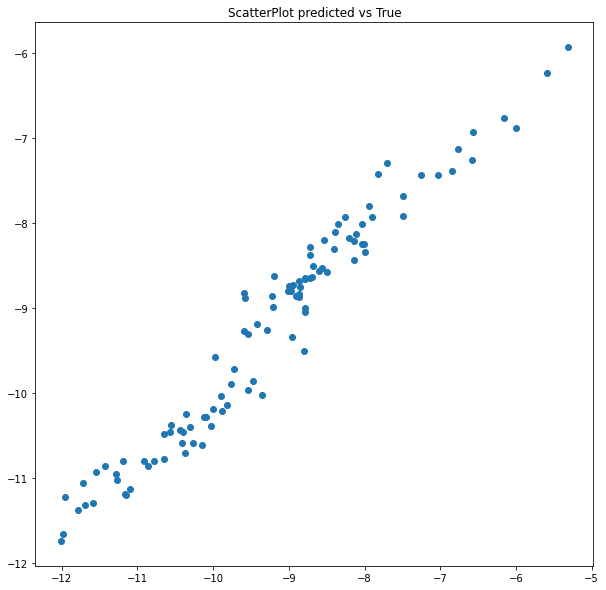

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02322
Feature:               commutersdensity, Score: 0.01724
Feature:                         depriv, Score: 0.03585
Feature:                            lat, Score: 0.64873
Feature:                 Ratio0200ver65, Score: 0.06060
Feature:           avg_wco_period1_2020, Score: 0.06296
Feature:          avg_wnh3_period1_2020, Score: 0.09168
Feature:         avg_wpans_period1_2020, Score: 0.02741
Feature:          avg_wso2_period1_2020, Score: 0.03231


<Figure size 432x288 with 0 Axes>

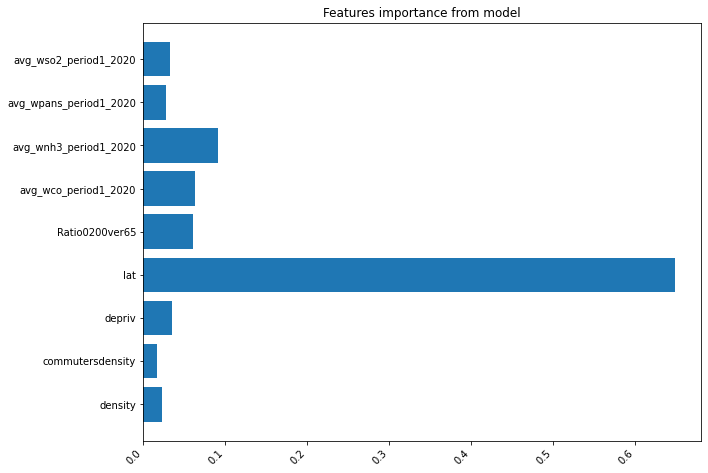

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04865 +/- 0.00449
Feature:               commutersdensity, Score: 0.03043 +/- 0.00290
Feature:                         depriv, Score: 0.05931 +/- 0.00555
Feature:                            lat, Score: 2.91907 +/- 0.41187
Feature:                 Ratio0200ver65, Score: 0.13079 +/- 0.01868
Feature:           avg_wco_period1_2020, Score: 0.20774 +/- 0.03677
Feature:          avg_wnh3_period1_2020, Score: 0.21190 +/- 0.02681
Feature:         avg_wpans_period1_2020, Score: 0.07362 +/- 0.00827
Feature:          avg_wso2_period1_2020, Score: 0.05499 +/- 0.00717


<Figure size 432x288 with 0 Axes>

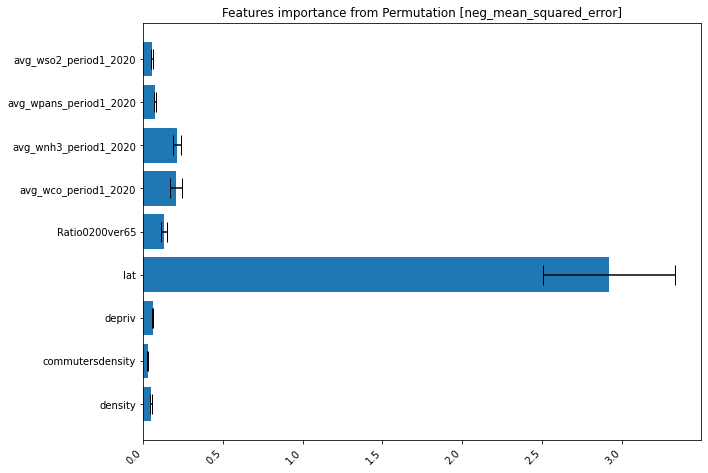

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02226 +/- 0.00205
Feature:               commutersdensity, Score: 0.01392 +/- 0.00133
Feature:                         depriv, Score: 0.02714 +/- 0.00254
Feature:                            lat, Score: 1.33580 +/- 0.18848
Feature:                 Ratio0200ver65, Score: 0.05985 +/- 0.00855
Feature:           avg_wco_period1_2020, Score: 0.09506 +/- 0.01683
Feature:          avg_wnh3_period1_2020, Score: 0.09697 +/- 0.01227
Feature:         avg_wpans_period1_2020, Score: 0.03369 +/- 0.00378
Feature:          avg_wso2_period1_2020, Score: 0.02516 +/- 0.00328


<Figure size 432x288 with 0 Axes>

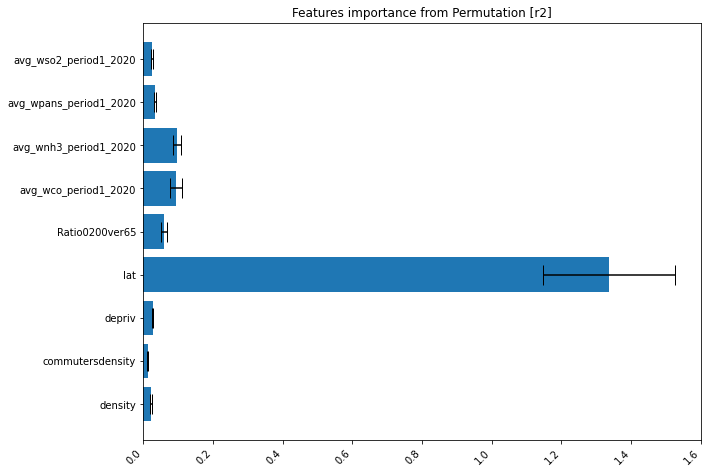

<Figure size 720x720 with 0 Axes>

((0.3557243656254323, 0.02220975544626933),
 (0.9421668097172425, 0.1008862773261045),
 0.3413022672244384,
 {'density': 0.013020563640399416,
  'commutersdensity': 0.00814327393676228,
  'depriv': 0.015872482375324425,
  'lat': 0.7812327181415377,
  'Ratio0200ver65': 0.03500244501704043,
  'avg_wco_period1_2020': 0.055596513891622464,
  'avg_wnh3_period1_2020': 0.05671192565004865,
  'avg_wpans_period1_2020': 0.019704322703356897,
  'avg_wso2_period1_2020': 0.014715754643907673},
 {'density': 0.013020563640399394,
  'commutersdensity': 0.008143273936762258,
  'depriv': 0.015872482375324407,
  'lat': 0.7812327181415378,
  'Ratio0200ver65': 0.035002445017040425,
  'avg_wco_period1_2020': 0.05559651389162246,
  'avg_wnh3_period1_2020': 0.05671192565004863,
  'avg_wpans_period1_2020': 0.019704322703356876,
  'avg_wso2_period1_2020': 0.014715754643907657})

<Figure size 432x288 with 0 Axes>

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures", showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.11648723761254197
2  of  1200 MSE:  0.10697892650918264
3  of  1200 MSE:  0.17713292763536884
4  of  1200 MSE:  0.20645975601109687
5  of  1200 MSE:  0.40085847609188335
6  of  1200 MSE:  0.4709918648497158
7  of  1200 MSE:  0.5817169046053062
8  of  1200 MSE:  0.665011990962319
9  of  1200 MSE:  0.16864171497023206
10  of  1200 MSE:  0.19457261355081873
11  of  1200 MSE:  0.19813510041760482
12  of  1200 MSE:  0.2414558017905361
13  of  1200 MSE:  0.40085847609188335
14  of  1200 MSE:  0.4709918648497158
15  of  1200 MSE:  0.5817169046053062
16  of  1200 MSE:  0.665011990962319
17  of  1200 MSE:  0.2797962968929491
18  of  1200 MSE:  0.3130536906976215
19  of  1200 MSE:  0.30540592144674483
20  of  1200 MSE:  0.35300479616939195
21  of  1200 MSE:  0.40085847609188335
22  of  1200 MSE:  0.4709918648497158
23  of  1200 MSE:  0.5817169046053062
24  of  1200 MSE:  0.665011990962319
25  of  1200 MSE:  0.3873731923630847
26  of  1200 MSE:  0.43280031238609307
27  of  120

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 1}
Training set average RMSE:  0.35829  0.01811 
    Test set average RMSE:  0.90046  0.08356 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.32708
                       R2:  0.95104


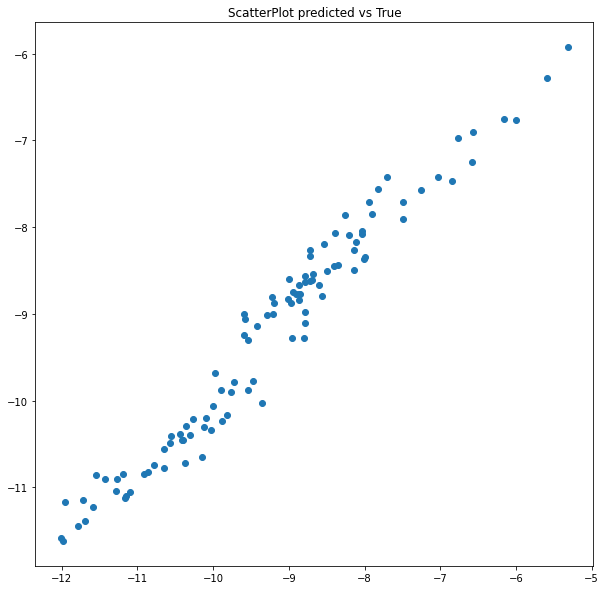

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04233
Feature:               commutersdensity, Score: 0.18204
Feature:                         depriv, Score: 0.09894
Feature:                            lat, Score: 0.30135
Feature:                 Ratio0200ver65, Score: 0.06315
Feature:           avg_wco_period1_2020, Score: 0.12497
Feature:          avg_wnh3_period1_2020, Score: 0.10855
Feature:         avg_wpans_period1_2020, Score: 0.03470
Feature:          avg_wso2_period1_2020, Score: 0.04397


<Figure size 432x288 with 0 Axes>

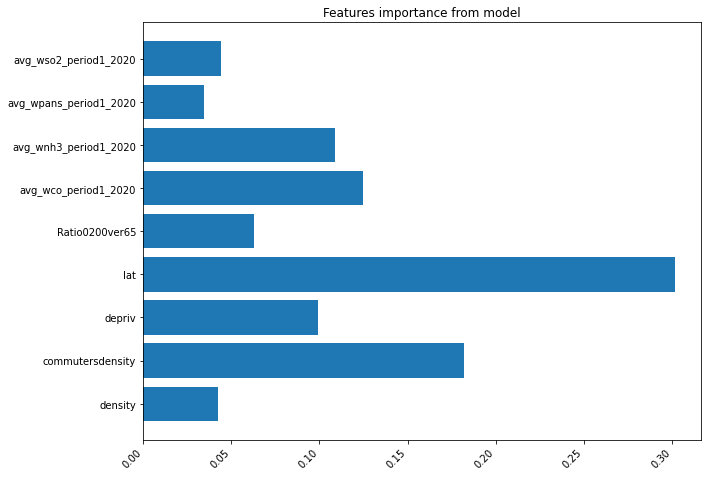

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04477 +/- 0.00390
Feature:               commutersdensity, Score: 0.04065 +/- 0.00374
Feature:                         depriv, Score: 0.05046 +/- 0.00484
Feature:                            lat, Score: 2.88856 +/- 0.40819
Feature:                 Ratio0200ver65, Score: 0.11549 +/- 0.01785
Feature:           avg_wco_period1_2020, Score: 0.19326 +/- 0.03021
Feature:          avg_wnh3_period1_2020, Score: 0.23489 +/- 0.02715
Feature:         avg_wpans_period1_2020, Score: 0.07380 +/- 0.00840
Feature:          avg_wso2_period1_2020, Score: 0.06371 +/- 0.00693


<Figure size 432x288 with 0 Axes>

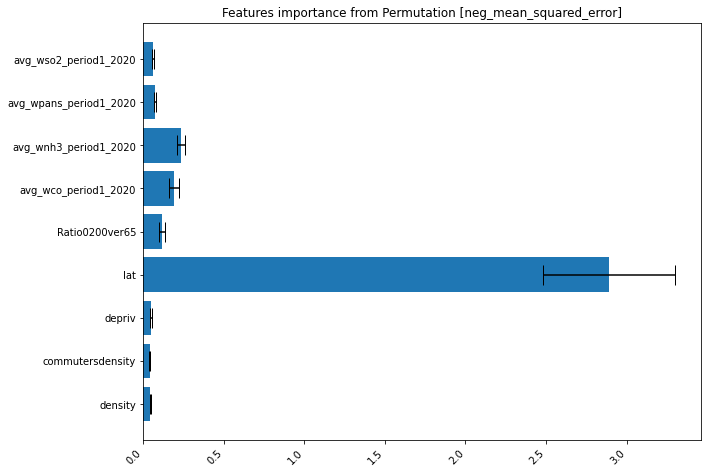

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02049 +/- 0.00178
Feature:               commutersdensity, Score: 0.01860 +/- 0.00171
Feature:                         depriv, Score: 0.02309 +/- 0.00221
Feature:                            lat, Score: 1.32184 +/- 0.18679
Feature:                 Ratio0200ver65, Score: 0.05285 +/- 0.00817
Feature:           avg_wco_period1_2020, Score: 0.08844 +/- 0.01382
Feature:          avg_wnh3_period1_2020, Score: 0.10749 +/- 0.01242
Feature:         avg_wpans_period1_2020, Score: 0.03377 +/- 0.00384
Feature:          avg_wso2_period1_2020, Score: 0.02915 +/- 0.00317


<Figure size 432x288 with 0 Axes>

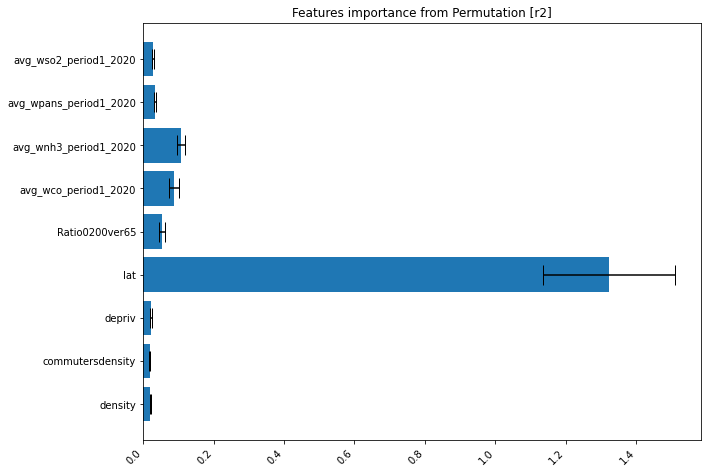

<Figure size 720x720 with 0 Axes>

((0.35829431858302013, 0.01810537064581932),
 (0.9004593943776146, 0.08355694730239424),
 0.32707633131913205,
 {'density': 0.012082603487231686,
  'commutersdensity': 0.010971193644558157,
  'depriv': 0.013618068098500245,
  'lat': 0.7795106778849992,
  'Ratio0200ver65': 0.031167110861273904,
  'avg_wco_period1_2020': 0.05215326239980588,
  'avg_wnh3_period1_2020': 0.06338843526637121,
  'avg_wpans_period1_2020': 0.019916698962243046,
  'avg_wso2_period1_2020': 0.017191949395016632},
 {'density': 0.012082603487231666,
  'commutersdensity': 0.010971193644558138,
  'depriv': 0.013618068098500231,
  'lat': 0.7795106778849993,
  'Ratio0200ver65': 0.0311671108612739,
  'avg_wco_period1_2020': 0.05215326239980589,
  'avg_wnh3_period1_2020': 0.06338843526637118,
  'avg_wpans_period1_2020': 0.01991669896224303,
  'avg_wso2_period1_2020': 0.01719194939501662})

<Figure size 432x288 with 0 Axes>

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.38313  0.03048 
    Test set average RMSE:  1.01388  0.11339 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36513
                       R2:  0.93899


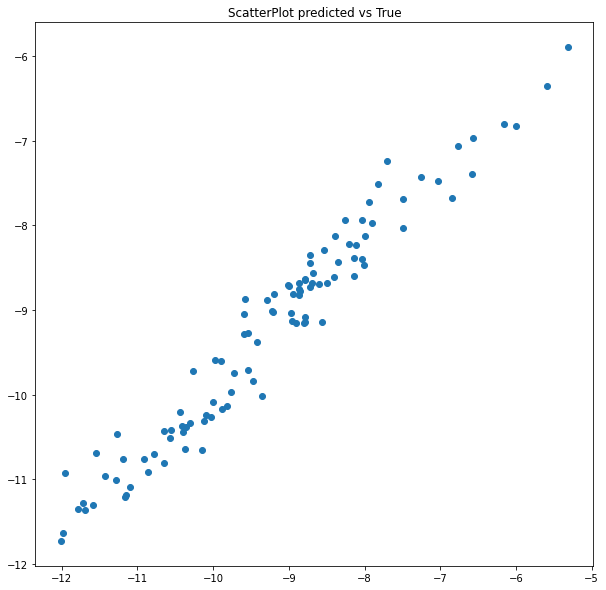

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03901
Feature:               commutersdensity, Score: 0.49463
Feature:                         depriv, Score: 0.04746
Feature:                 Ratio0200ver65, Score: 0.10992
Feature:           avg_wco_period1_2020, Score: 0.11160
Feature:          avg_wnh3_period1_2020, Score: 0.10908
Feature:         avg_wpans_period1_2020, Score: 0.04240
Feature:          avg_wso2_period1_2020, Score: 0.04590


<Figure size 432x288 with 0 Axes>

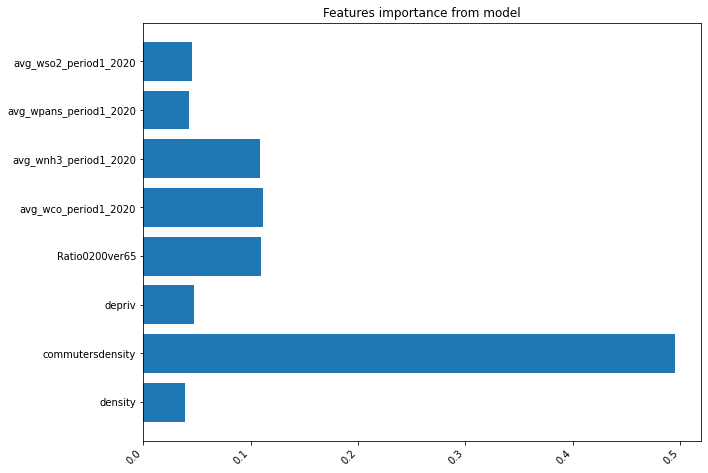

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.06528 +/- 0.00589
Feature:               commutersdensity, Score: 1.78928 +/- 0.27013
Feature:                         depriv, Score: 0.06624 +/- 0.01009
Feature:                 Ratio0200ver65, Score: 0.24205 +/- 0.03186
Feature:           avg_wco_period1_2020, Score: 0.37601 +/- 0.05371
Feature:          avg_wnh3_period1_2020, Score: 0.23399 +/- 0.03159
Feature:         avg_wpans_period1_2020, Score: 0.11286 +/- 0.01667
Feature:          avg_wso2_period1_2020, Score: 0.10551 +/- 0.01301


<Figure size 432x288 with 0 Axes>

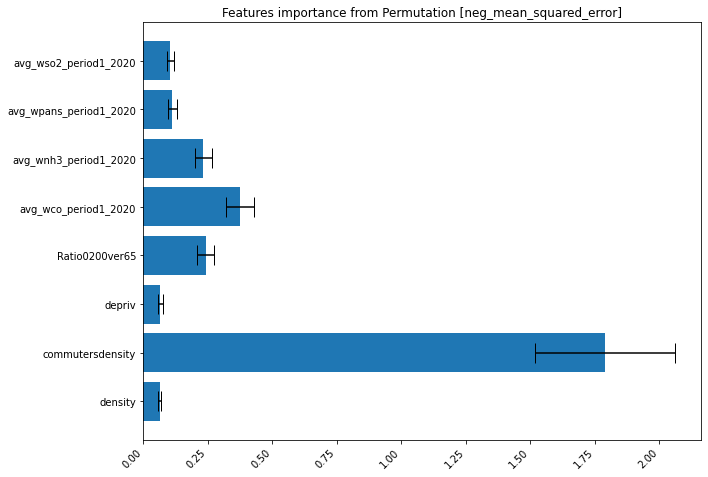

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02987 +/- 0.00269
Feature:               commutersdensity, Score: 0.81880 +/- 0.12362
Feature:                         depriv, Score: 0.03031 +/- 0.00462
Feature:                 Ratio0200ver65, Score: 0.11077 +/- 0.01458
Feature:           avg_wco_period1_2020, Score: 0.17207 +/- 0.02458
Feature:          avg_wnh3_period1_2020, Score: 0.10708 +/- 0.01446
Feature:         avg_wpans_period1_2020, Score: 0.05165 +/- 0.00763
Feature:          avg_wso2_period1_2020, Score: 0.04829 +/- 0.00595


<Figure size 432x288 with 0 Axes>

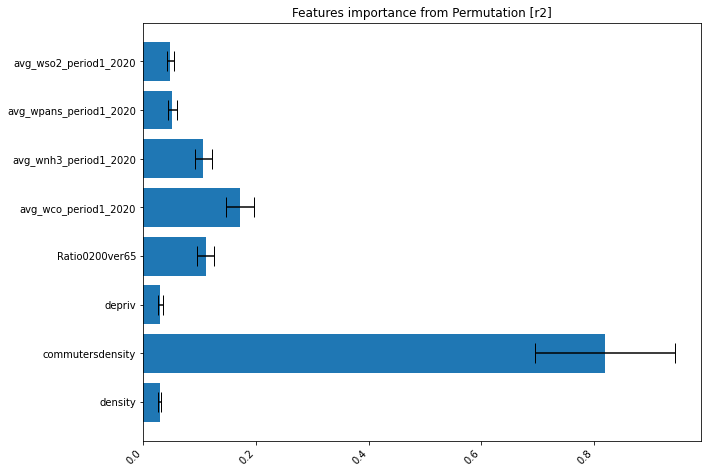

<Figure size 720x720 with 0 Axes>

((0.38313310442593607, 0.030478882565924372),
 (1.013882995904084, 0.11339017903147505),
 0.36513349495141323,
 {'density': 0.021824028718335088,
  'commutersdensity': 0.5981735026677001,
  'depriv': 0.022145865731934385,
  'Ratio0200ver65': 0.08092064672272366,
  'avg_wco_period1_2020': 0.12570471934894756,
  'avg_wnh3_period1_2020': 0.0782246158542204,
  'avg_wpans_period1_2020': 0.03773191823282357,
  'avg_wso2_period1_2020': 0.03527470272331516},
 {'density': 0.021824028718335057,
  'commutersdensity': 0.5981735026677002,
  'depriv': 0.022145865731934354,
  'Ratio0200ver65': 0.08092064672272366,
  'avg_wco_period1_2020': 0.12570471934894756,
  'avg_wnh3_period1_2020': 0.07822461585422039,
  'avg_wpans_period1_2020': 0.03773191823282355,
  'avg_wso2_period1_2020': 0.03527470272331513})

<Figure size 432x288 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.13332246913543372
2  of  1200 MSE:  0.12793611227407192
3  of  1200 MSE:  0.2077220267185857
4  of  1200 MSE:  0.2734189300285387
5  of  1200 MSE:  0.48715710103639115
6  of  1200 MSE:  0.5921468438859327
7  of  1200 MSE:  0.7158899149317951
8  of  1200 MSE:  0.8107550157697094
9  of  1200 MSE:  0.19964849557288458
10  of  1200 MSE:  0.22646118711830082
11  of  1200 MSE:  0.23510995775194193
12  of  1200 MSE:  0.3088503203217894
13  of  1200 MSE:  0.48715710103639115
14  of  1200 MSE:  0.5921468438859327
15  of  1200 MSE:  0.7158899149317951
16  of  1200 MSE:  0.8107550157697094
17  of  1200 MSE:  0.3315658692718821
18  of  1200 MSE:  0.40469109446565127
19  of  1200 MSE:  0.36309616806446693
20  of  1200 MSE:  0.4570030880168993
21  of  1200 MSE:  0.48715710103639115
22  of  1200 MSE:  0.5921468438859327
23  of  1200 MSE:  0.7158899149317951
24  of  1200 MSE:  0.8107550157697094
25  of  1200 MSE:  0.46741178054508653
26  of  1200 MSE:  0.5430147229905903
27  of  12

Training set average RMSE:  0.37039  0.02232 
    Test set average RMSE:  0.99053  0.09793 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35237
                       R2:  0.94318


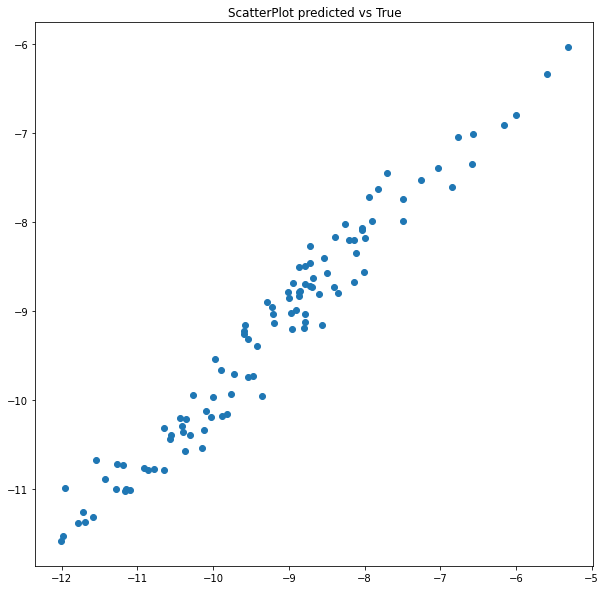

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.07228
Feature:               commutersdensity, Score: 0.23149
Feature:                         depriv, Score: 0.15233
Feature:                 Ratio0200ver65, Score: 0.08908
Feature:           avg_wco_period1_2020, Score: 0.17999
Feature:          avg_wnh3_period1_2020, Score: 0.13858
Feature:         avg_wpans_period1_2020, Score: 0.05573
Feature:          avg_wso2_period1_2020, Score: 0.08052


<Figure size 432x288 with 0 Axes>

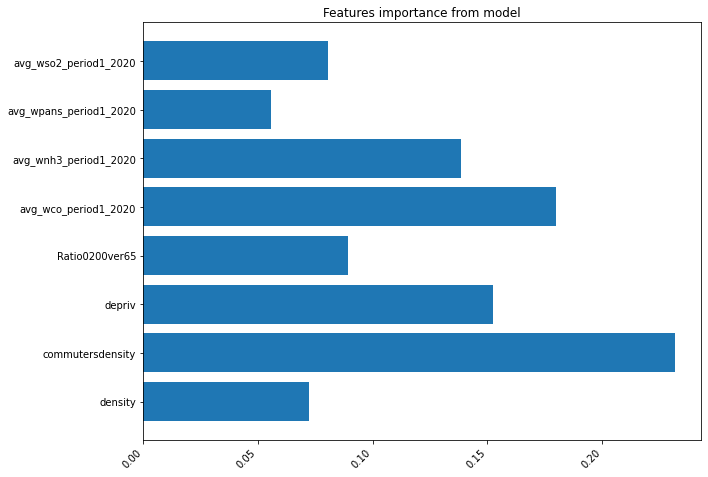

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05917 +/- 0.00557
Feature:               commutersdensity, Score: 1.77906 +/- 0.27516
Feature:                         depriv, Score: 0.06709 +/- 0.00770
Feature:                 Ratio0200ver65, Score: 0.25068 +/- 0.03457
Feature:           avg_wco_period1_2020, Score: 0.35431 +/- 0.04868
Feature:          avg_wnh3_period1_2020, Score: 0.25347 +/- 0.03573
Feature:         avg_wpans_period1_2020, Score: 0.10722 +/- 0.01673
Feature:          avg_wso2_period1_2020, Score: 0.12002 +/- 0.01556


<Figure size 432x288 with 0 Axes>

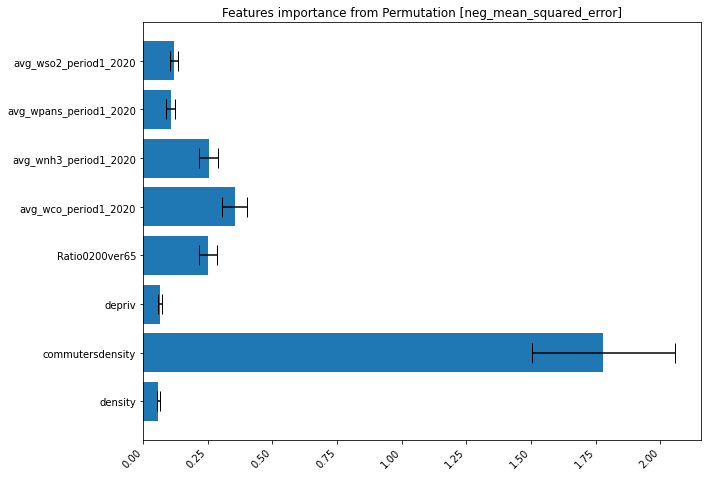

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02708 +/- 0.00255
Feature:               commutersdensity, Score: 0.81412 +/- 0.12592
Feature:                         depriv, Score: 0.03070 +/- 0.00353
Feature:                 Ratio0200ver65, Score: 0.11471 +/- 0.01582
Feature:           avg_wco_period1_2020, Score: 0.16214 +/- 0.02228
Feature:          avg_wnh3_period1_2020, Score: 0.11599 +/- 0.01635
Feature:         avg_wpans_period1_2020, Score: 0.04907 +/- 0.00765
Feature:          avg_wso2_period1_2020, Score: 0.05492 +/- 0.00712


<Figure size 432x288 with 0 Axes>

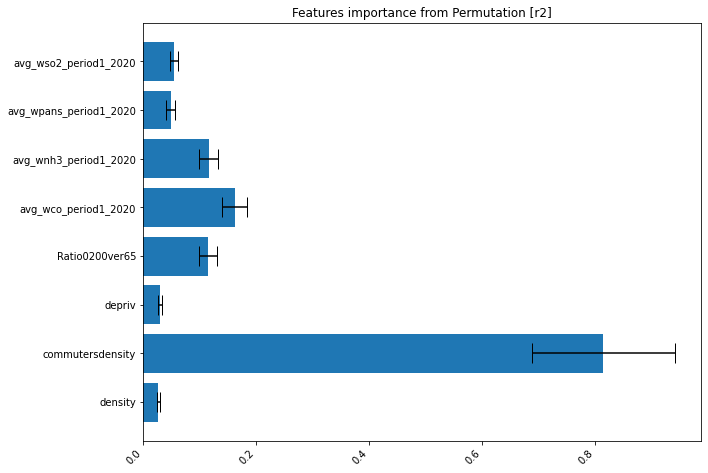

<Figure size 720x720 with 0 Axes>

((0.37039395912020145, 0.022324348806364414),
 (0.9905342538406849, 0.09793391937931205),
 0.3523731881352535,
 {'density': 0.019783331019690046,
  'commutersdensity': 0.59479948857454,
  'depriv': 0.02243076731077655,
  'Ratio0200ver65': 0.08381037010309642,
  'avg_wco_period1_2020': 0.11845681426548041,
  'avg_wnh3_period1_2020': 0.0847430282191338,
  'avg_wpans_period1_2020': 0.035848612030779735,
  'avg_wso2_period1_2020': 0.040127588476503134},
 {'density': 0.01978333101969002,
  'commutersdensity': 0.59479948857454,
  'depriv': 0.022430767310776527,
  'Ratio0200ver65': 0.0838103701030964,
  'avg_wco_period1_2020': 0.11845681426548035,
  'avg_wnh3_period1_2020': 0.08474302821913376,
  'avg_wpans_period1_2020': 0.035848612030779714,
  'avg_wso2_period1_2020': 0.040127588476503114})

<Figure size 432x288 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.40730  0.02812 
    Test set average RMSE:  1.11342  0.10907 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.38802
                       R2:  0.93110


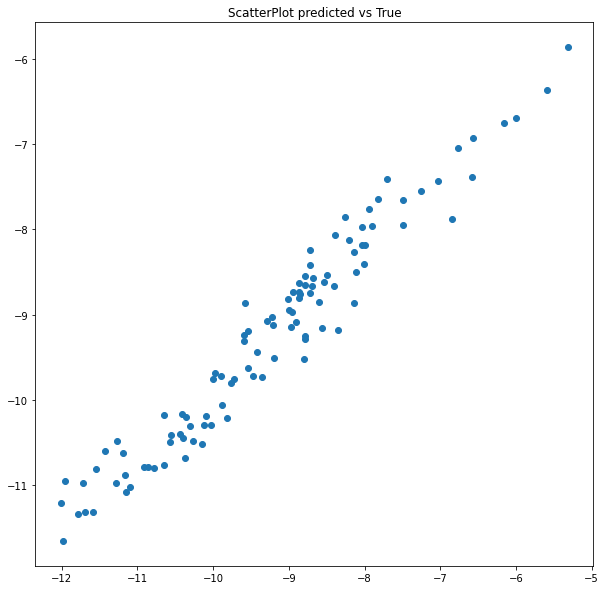

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04593
Feature:                         depriv, Score: 0.22146
Feature:                 Ratio0200ver65, Score: 0.10525
Feature:           avg_wco_period1_2020, Score: 0.30126
Feature:          avg_wnh3_period1_2020, Score: 0.16670
Feature:         avg_wpans_period1_2020, Score: 0.06761
Feature:          avg_wso2_period1_2020, Score: 0.09179


<Figure size 432x288 with 0 Axes>

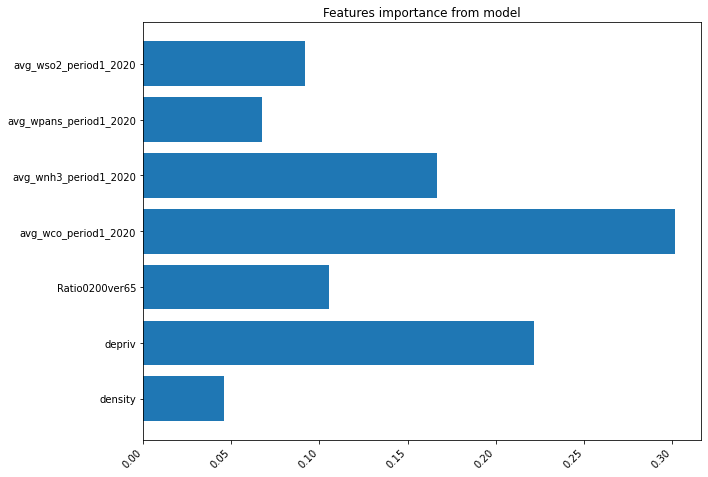

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.08640 +/- 0.01008
Feature:                         depriv, Score: 0.72214 +/- 0.11429
Feature:                 Ratio0200ver65, Score: 0.21045 +/- 0.02837
Feature:           avg_wco_period1_2020, Score: 0.73745 +/- 0.10573
Feature:          avg_wnh3_period1_2020, Score: 0.42674 +/- 0.05668
Feature:         avg_wpans_period1_2020, Score: 0.19175 +/- 0.02506
Feature:          avg_wso2_period1_2020, Score: 0.17938 +/- 0.02222


<Figure size 432x288 with 0 Axes>

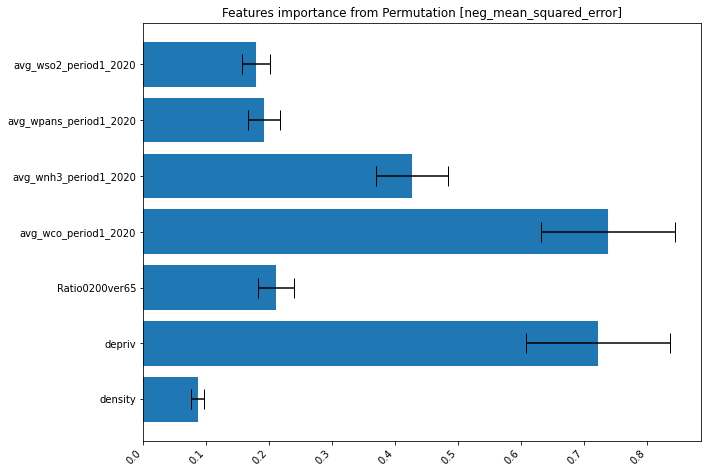

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.03954 +/- 0.00461
Feature:                         depriv, Score: 0.33046 +/- 0.05230
Feature:                 Ratio0200ver65, Score: 0.09630 +/- 0.01298
Feature:           avg_wco_period1_2020, Score: 0.33747 +/- 0.04838
Feature:          avg_wnh3_period1_2020, Score: 0.19528 +/- 0.02594
Feature:         avg_wpans_period1_2020, Score: 0.08775 +/- 0.01147
Feature:          avg_wso2_period1_2020, Score: 0.08209 +/- 0.01017


<Figure size 432x288 with 0 Axes>

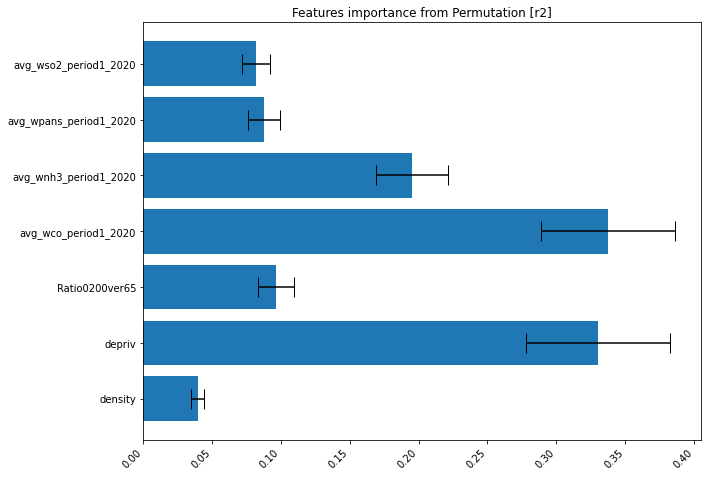

<Figure size 720x720 with 0 Axes>

((0.40729823738542853, 0.028122266106281362),
 (1.113419573521942, 0.10906831813782297),
 0.3880187828257375,
 {'density': 0.03382676429971105,
  'depriv': 0.28271585654896886,
  'Ratio0200ver65': 0.0823892097885141,
  'avg_wco_period1_2020': 0.28870847707580605,
  'avg_wnh3_period1_2020': 0.16706573045479572,
  'avg_wpans_period1_2020': 0.07506783537649672,
  'avg_wso2_period1_2020': 0.07022612645570761},
 {'density': 0.03382676429971103,
  'depriv': 0.28271585654896886,
  'Ratio0200ver65': 0.08238920978851409,
  'avg_wco_period1_2020': 0.288708477075806,
  'avg_wnh3_period1_2020': 0.16706573045479567,
  'avg_wpans_period1_2020': 0.07506783537649672,
  'avg_wso2_period1_2020': 0.0702261264557076})

<Figure size 432x288 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocommut", pout=sys.stdout, showplot=True)

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.15055857582556684
2  of  1200 MSE:  0.13854542327417024
3  of  1200 MSE:  0.22888895747334576
4  of  1200 MSE:  0.29436400979176275
5  of  1200 MSE:  0.5539447849957925
6  of  1200 MSE:  0.6457813490796522
7  of  1200 MSE:  0.8256912979459293
8  of  1200 MSE:  0.901172653935632
9  of  1200 MSE:  0.2074543423475631
10  of  1200 MSE:  0.24503266011047023
11  of  1200 MSE:  0.2506025116772867
12  of  1200 MSE:  0.3208263157300243
13  of  1200 MSE:  0.5539447849957925
14  of  1200 MSE:  0.6457813490796522
15  of  1200 MSE:  0.8256912979459293
16  of  1200 MSE:  0.901172653935632
17  of  1200 MSE:  0.35748326846100653
18  of  1200 MSE:  0.4196931059720738
19  of  1200 MSE:  0.3887828177109771
20  of  1200 MSE:  0.47544543222539026
21  of  1200 MSE:  0.5539447849957925
22  of  1200 MSE:  0.6457813490796522
23  of  1200 MSE:  0.8256912979459293
24  of  1200 MSE:  0.901172653935632
25  of  1200 MSE:  0.4985619067777715
26  of  1200 MSE:  0.5700535206669648
27  of  1200 MSE:

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocommut_opt", showplot=True, optimisedparams=bestf)